- 시작 하기 전에

처음부터 전부 작동시키면 하루정도 걸려야 다 돌아가니 가급적 제가드린 데이터파일(중간 세이브 파일 개념)을 사용해주세요.

밑바닥부터 다 돌려보고 싶다면 dataguide에서 데이터 받아서 돌리시면 됩니다만 권장하진 않습니다.

In [1]:
import pandas as pd
import glob
from tqdm import tqdm
import os
import warnings
import gc
import numpy as np
import itertools
from tqdm import tqdm
import hotshot as hs
# import networkx as nx  # networkx 임포트
# from causalnex.structure.notears import from_pandas
# from causalnex.network import BayesianNetwork
# from econml.dr import DRLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import Loss
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow as tf
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from datetime import timedelta
import warnings

warnings.filterwarnings('ignore')

# 팩터 전략별로 필요한 데이터를 계산하여 monthly_merged_df에 추가합니다.

if 'monthly_merged_df' not in globals():
    monthly_merged_df = pd.read_csv(
        'data/merged_df_monthly_preprocessing.csv',
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )

pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

# CSV 부르기 및 기본적인 전처리 : 돌릴 필요 없음.

In [3]:
# DataFrame을 저장할 리스트 생성
df_list = []

# 1. 'data' 폴더 내에 'KSIF'가 포함된 CSV 파일 목록 가져오기
file_list = glob.glob('data/*KSIF*.csv')

# 파일이 존재하는지 확인
if not file_list:
    print("패턴에 맞는 파일을 찾을 수 없습니다.")
elif os.path.exists('data/merged_df_monthly.csv'):
    print("이미 통합한 월별 데이터 파일이 존재합니다. 해당 CSV를 불러옵니다.")
    merged_df_backup = pd.read_csv(
        'data/merged_df_monthly.csv',
        header=[0, 1, 2, 3],
        index_col=0,  # 첫 번째 열을 인덱스로 사용
        parse_dates=True  # 인덱스를 datetime으로 파싱
    )
    print("월별 CSV를 불러왔습니다.")
elif os.path.exists('data/merged_data.csv'):
    print("이미 통합한 일별 데이터 파일이 존재합니다. 해당 CSV를 월별로 전환합니다.")
    merged_df_backup = pd.read_csv(
        'data/merged_data.csv',
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )
    # 인덱스를 datetime으로 변환
    merged_df_backup.index = pd.to_datetime(merged_df_backup.index, errors='coerce')
    
    # 월별 리샘플링
    merged_df_backup = merged_df_backup.resample('M').last()
    
    # 월별 데이터 저장
    merged_df_backup.to_csv('data/merged_df_monthly.csv', encoding='utf-8-sig')
    
    print("월별 리샘플링된 데이터가 'merged_df_monthly.csv'로 저장되었습니다.")
    print("월별 CSV를 불러왔습니다.")
else:
    # tqdm을 사용하여 진행 상황 표시
    for file_path in tqdm(file_list, desc="파일 처리 중"):
        # 각 CSV 파일 읽기 (적절한 인코딩과 인덱스 설정)
        try:
            df = pd.read_csv(
                file_path,
                skiprows=8,
                header=[0, 1, 2, 3, 4, 5],
                index_col=0,  # 첫 번째 열을 인덱스로 사용
                encoding='cp949',
                parse_dates=True
            )
        except UnicodeDecodeError:
            # 'cp949' 인코딩이 안 될 경우 'euc-kr'로 시도
            df = pd.read_csv(
                file_path,
                skiprows=8,
                header=[0, 1, 2, 3, 4, 5],
                index_col=0,
                encoding='euc-kr',
                parse_dates=True
            )
        except Exception as e:
            print(f"파일 {file_path}를 로드하는 중 에러 발생: {e}")
            continue  # 에러 발생 시 다음 파일로 넘어감
        
        # 멀티인덱스 컬럼에 이름 지정
        df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']
        
        # 인덱스 이름 지정 ('Date'로 설정)
        df.index.name = 'Date'
        
        # 인덱스를 datetime으로 변환
        df.index = pd.to_datetime(df.index, errors='coerce')
        
        # 'Kind', 'Frequency' 레벨 제거하여 필요한 컬럼만 남김
        df.columns = df.columns.droplevel(['Kind', 'Frequency'])
        
        # 리스트에 DataFrame 추가
        df_list.append(df)
    
    # 2. 모든 DataFrame을 수평적으로 병합
    print("DataFrame 병합 중...")
    merged_df_backup = pd.concat(df_list, axis=1)
    del df_list  # 리스트 메모리에서 삭제
    gc.collect()  # 가비지 컬렉션 실행
    
    # 월별 리샘플링
    print("월별 리샘플링 중...")
    merged_df_backup = merged_df_backup.resample('M').last()
    
    # 월별 데이터 저장
    merged_df_backup.to_csv('data/merged_df_monthly.csv', encoding='utf-8-sig')
    
    print("월별 리샘플링된 데이터가 'merged_df_monthly.csv'로 저장되었습니다.")
    
    # 필요에 따라 일별 데이터를 저장하려면 아래 주석을 해제하세요.
    # merged_df_backup.to_csv('data/merged_data.csv', encoding='utf-8-sig')
    # print("모든 CSV 파일을 병합하여 'merged_data.csv'로 저장했습니다.")

    # 메모리 관리
    del merged_df_backup
    gc.collect()

이미 통합한 월별 데이터 파일이 존재합니다. 해당 CSV를 불러옵니다.
월별 CSV를 불러왔습니다.


In [2]:
def check_dataframe_issues(df_list):
    """
    점검 함수: 데이터프레임 리스트에서 고유하지 않은 인덱스와 기준 인덱스 불일치 확인
    Args:
        df_list (list): pandas 데이터프레임들의 리스트
    Returns:
        dict: 문제를 가진 데이터프레임의 인덱스 (non_unique_index, mismatched_index)
    """
    # 결과 저장용 딕셔너리
    issues = {"non_unique_index": [], "mismatched_index": []}
    
    # 기준 인덱스는 첫 번째 데이터프레임의 인덱스로 설정
    base_index = df_list[0].index

    # 각 데이터프레임 점검
    for i, df in enumerate(df_list):
        # 1. 고유하지 않은 인덱스 확인
        if not df.index.is_unique:
            issues["non_unique_index"].append(i)
        
        # 2. 기준 인덱스와 불일치 확인
        if not base_index.equals(df.index):
            issues["mismatched_index"].append(i)

    return issues

# 점검 실행
check_dataframe_issues(df_list)#여기서 인덱스 2번이 뜨는 이유는 얘가 하루 더 있거등요 ㅇㅇ

IndexError: list index out of range

In [3]:
merged_df_backup.columns.get_level_values(3).unique()#우리 데이터 뭐있나 함 볼까?

Index(['수정주가(원)', 'PER(보통)(배)', 'PER(직전4분기)(배)', 'PER(보통,자사주차감)(배)',
       'BPS(발표기준기말주식수)(원)', 'BPS(자사주차감)(원)', '상장주식수(주)', '시가총액 (평균)(원)',
       '상장주식수 (보통)(주)', '매출총이익(원)', '총자산(원)', '유동자산(원)', '현금및현금성자산(원)',
       '유동부채(원)', '단기차입금(원)', '이연법인세부채(원)', '거래대금(원)', '관리종목지정사유', '기타포괄손익(원)',
       '베타 (M,3Yr)', '베타 (D,1Yr)', '보통주자본금(원)', '수익률(%)', '수익률 (1개월)(%)',
       '수정주가 (52주 최고)(원)', '유무형자산상각비(원)', '이익잉여금(원)', 'Unnamed: 3182_level_4',
       '이익잉여금(천원)'],
      dtype='object', name='item Name')

In [ ]:
import numpy as np

# 월별 데이터로 작업할 merged_df 생성
merged_df = merged_df_backup.copy()

# 1. "(원)"으로 끝나는 컬럼 처리
# 'item Name'이 '(원)'으로 끝나는 컬럼 선택
won_mask = merged_df.columns.get_level_values('item Name').str.endswith('(원)')

# 쉼표 제거 및 숫자 변환을 벡터화된 연산으로 수행
# 문자열 'None', 'nan', '', 'N/A' 등을 NaN으로 변환
merged_df.loc[:, won_mask] = (
    merged_df.loc[:, won_mask]
    .astype(str)  # 모든 데이터를 문자열로 변환
    .replace(',', '', regex=True)  # 쉼표 제거
    .replace(['', 'None', 'nan', 'NaN', 'N/A'], np.nan)  # 비정상적인 값들을 NaN으로 변환
    .apply(pd.to_numeric, errors='coerce')  # 숫자로 변환 (변환 불가 시 NaN)
)

print("'(원)' 컬럼의 문자열 변환 및 숫자 변환 완료")

# 2. '홀딩스', '지주', '스펙'으로 끝나는 종목 제거
pattern = ('홀딩스', '지주', '스펙', '스팩')
symbol_names = merged_df.columns.get_level_values('Symbol Name')
mask = symbol_names.str.endswith(pattern)
merged_df = merged_df.loc[:, ~mask]

# 3. '관리종목지정사유' 처리
# '관리종목지정사유'가 있는 종목 추출
management_mask = merged_df.columns.get_level_values('item Name') == '관리종목지정사유'
management_df = merged_df.loc[:, management_mask]

# 인덱스를 datetime 형태로 변환
merged_df.index = pd.to_datetime(merged_df.index, errors='coerce')

# 각 종목별로 처리
for symbol in management_df.columns.get_level_values('Symbol').unique():
    symbol_management = management_df.loc[:, management_df.columns.get_level_values('Symbol') == symbol]
    
    # NaN이 아닌 첫 번째 날짜 찾기
    dates_with_issue = symbol_management[symbol_management.notna().any(axis=1)].index
    
    if not dates_with_issue.empty:
        try:
            # 이슈 발생 날짜
            issue_date = dates_with_issue[0]
            
            # 해당 Symbol의 데이터를 처리
            symbol_mask = merged_df.columns.get_level_values('Symbol') == symbol
            price_mask = merged_df.columns.get_level_values('item Name') == '수정주가(원)'
            other_mask = symbol_mask & ~price_mask
            
            # 이슈 발생 월부터 이후 데이터에 대해 NaN으로 설정 (수정주가는 제외)
            merged_df.loc[merged_df.index >= issue_date, other_mask] = np.nan
            
        except Exception as e:
            print(f"Error processing symbol: {symbol}, issue_date: {issue_date}, Error: {e}")

print('관리종목 포트폴리오 정상화')

# 4. '거래대금(원)' 기반 종목 제거
trading_value_mask = merged_df.columns.get_level_values('item Name') == '거래대금(원)'
trading_value_df = merged_df.loc[:, trading_value_mask]

# 인덱스를 datetime으로 변환
trading_value_df.index = pd.to_datetime(trading_value_df.index)

# 2014년 이후 데이터 선택
trading_value_df = trading_value_df[trading_value_df.index >= '2014-01-31']

# 문자열을 숫자로 변환 (오류 발생 시 NaN 처리)
trading_value_df = trading_value_df.apply(pd.to_numeric, errors='coerce')

# 거래대금이 4천만원 이하인 경우 True, NaN은 False로 처리
low_trading_value = (trading_value_df <= 40000000).fillna(False)

# 각 Symbol마다 거래대금이 4천만원 이하인 달이 하나라도 있는지 확인
symbols_to_remove = low_trading_value.any(axis=0)
symbols_to_remove = symbols_to_remove[symbols_to_remove].index.get_level_values('Symbol').unique().tolist()

# 해당 Symbol 제거
symbol_mask = merged_df.columns.get_level_values('Symbol').isin(symbols_to_remove)
merged_df = merged_df.loc[:, ~symbol_mask]

print('market impact 조정 완료')

# 5. 수정주가 기반 1개월 수익률 계산
# 인덱스를 datetime으로 변환
merged_df.index = pd.to_datetime(merged_df.index)

# '수정주가(원)' 데이터 추출
price_mask = merged_df.columns.get_level_values('item Name') == '수정주가(원)'
price_df = merged_df.loc[:, price_mask]

# 월별 수익률 계산
returns_df = price_df.pct_change()

# 'item Name'을 '1개월 수익률(계산)'으로 변경
returns_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, item, '1개월 수익률(계산)') for symbol, symbol_name, item in zip(
        returns_df.columns.get_level_values('Symbol'),
        returns_df.columns.get_level_values('Symbol Name'),
        returns_df.columns.get_level_values('item')
    )],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 수익률 데이터를 merged_df에 추가
merged_df = pd.concat([merged_df, returns_df], axis=1)

print('1개월 수익률 계산 완료')

# 6. 결측치를 직전 값으로 대체
merged_df = merged_df.fillna(method='ffill')

print("전처리 완료")

In [ ]:
merged_df.to_csv('data/merged_df_monthly_preprocessing.csv', encoding='utf-8-sig')

In [22]:
merged_df_backup.dtypes

Symbol   Symbol Name  item        item Name       
A000660  SK하이닉스       S410000700  수정주가(원)               int64
                      6000701101  PER(보통)(배)          float64
                      6000701007  PER(직전4분기)(배)       float64
                      6000701006  PER(보통,자사주차감)(배)    float64
A373220  LG에너지솔루션     S410000700  수정주가(원)             float64
                                                       ...   
A900030  연합과기         S410000700  1개월 수익률(계산)         float64
A900060  중국식품포장       S410000700  1개월 수익률(계산)         float64
A900150  성융광전투자       S410000700  1개월 수익률(계산)         float64
A950030  네프로아이티       S410000700  1개월 수익률(계산)         float64
A950070  중국고섬         S410000700  1개월 수익률(계산)         float64
Length: 58059, dtype: object

# 팩터값 계산

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 팩터 전략별로 필요한 데이터를 계산하여 monthly_merged_df에 추가합니다.

if 'monthly_merged_df' not in globals():
    monthly_merged_df = pd.read_csv(
        'data/merged_df_monthly_preprocessing.csv',
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )

In [12]:
# ===== 팩터 전략 1: High P/E Ratio =====
# 상위 20% 종목에 롱 포지션, 하위 20% 종목에 숏 포지션을 취하는 전략

# 'PER(직전4분기)(배)' 데이터 추출
per_mask = monthly_merged_df.columns.get_level_values('item Name') == 'PER(보통,자사주차감)(배)'
per_df = monthly_merged_df.loc[:, per_mask]
per_df.columns = per_df.columns.droplevel(['item', 'item Name'])

# 결측치 처리 전에 per_df의 데이터를 float 타입으로 변환
per_df = per_df.apply(pd.to_numeric, errors='coerce')

# 결측치 처리
per_df = per_df.replace(0, np.nan)
per_df = per_df.replace(np.inf, np.nan)
per_df = per_df.fillna(method='ffill')

# 전체 종목에 대해 z-score 계산
per_zscore = -per_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# 팩터 값 저장
per_zscore.to_csv('factor_high_pe_ratio.csv', encoding='utf-8-sig')
print("'factor_high_pe_ratio.csv' 파일이 저장되었습니다.")

# 산업 분류 데이터 불러오기
try:
    industry_df = pd.read_csv(
        'data/industry.csv',
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )
except UnicodeDecodeError:
    industry_df = pd.read_csv(
        'data/industry.csv',
        header=[0, 1, 2, 3],
        index_col=0,  # 첫 번째 열을 인덱스로 사용
        encoding='cp949',
        parse_dates=True  # 인덱스를 datetime으로 파싱
    )
    
# 멀티인덱스 설정
industry_df.columns.names = ['Symbol', 'Symbol Name', 'item', 'item Name']
industry_df.index.name = 'Date'

# '한국표준산업분류10차(대분류)', '한국표준산업분류10차(중분류)' 데이터 추출
industry_large_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(대분류)'
industry_medium_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(중분류)'

industry_large_df = industry_df.loc[:, industry_large_mask]
industry_large_df.columns = industry_large_df.columns.droplevel(['item', 'item Name'])
industry_medium_df = industry_df.loc[:, industry_medium_mask]
industry_medium_df.columns = industry_medium_df.columns.droplevel(['item', 'item Name'])

# PER 데이터와 산업 분류 데이터의 인덱스 및 컬럼 정렬
per_df, industry_large_df = per_df.align(industry_large_df, join='inner', axis=1)
per_df, industry_medium_df = per_df.align(industry_medium_df, join='inner', axis=1)

# 디버깅 출력을 위한 함수
def debug_print(message, df=None):
    print(message)
    if df is not None:
        print(df.head())
        print(df.shape)
        print("-" * 50)

# 산업별로 z-score 계산
def industry_zscore(per_series, industry_series):
    df = pd.DataFrame({'PER': per_series, 'Industry': industry_series})
    # NaN 값이 있는 행 제거
    df = df.dropna()
    # 산업별 그룹화 및 z-score 계산
    grouped = df.groupby('Industry')
    z_scores = grouped['PER'].transform(lambda x: -(x - x.mean()) / x.std() if x.std() != 0 else 0)
    return z_scores

# 대분류 산업별 z-score
per_zscore_large = per_df.copy()
print(per_zscore_large.shape)
for date in per_zscore_large.index:
    per_zscore_large.loc[date] = industry_zscore(per_df.loc[date], industry_large_df.loc[date])
    # 디버깅 출력
    # debug_print(f"[Large Industry] Date: {date}", per_zscore_large.loc[[date]])

# 멀티레벨 컬럼 구조 설정
per_zscore_large.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'PER_zscore_large', 'PER_zscore_large') for symbol, symbol_name in per_zscore_large.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 팩터 값 저장
per_zscore_large.to_csv('factor_high_pe_ratio_large_industry.csv', encoding='utf-8-sig')
print("'factor_high_pe_ratio_large_industry.csv' 파일이 저장되었습니다.")

# 중분류 산업별 z-score
per_zscore_medium = per_df.copy()
for date in per_zscore_medium.index:
    per_zscore_medium.loc[date] = industry_zscore(per_df.loc[date], industry_medium_df.loc[date])
    # 디버깅 출력
    # debug_print(f"[Medium Industry] Date: {date}", per_zscore_medium.loc[[date]])

# 멀티레벨 컬럼 구조 설정
per_zscore_medium.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'PER_large', 'PER_large') for symbol, symbol_name in per_zscore_medium.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)
# 팩터 값 저장
per_zscore_medium.to_csv('factor_high_pe_ratio_medium_industry.csv', encoding='utf-8-sig')
print("'factor_high_pe_ratio_medium_industry.csv' 파일이 저장되었습니다.")

# 팩터 값 저장
per_zscore.to_csv('factor_high_pe_ratio.csv', encoding='utf-8-sig')

'factor_high_pe_ratio.csv' 파일이 저장되었습니다.
(206, 2052)
'factor_high_pe_ratio_large_industry.csv' 파일이 저장되었습니다.
'factor_high_pe_ratio_medium_industry.csv' 파일이 저장되었습니다.


In [7]:
# ===== 팩터 전략 2: HML (Kang, 2013) =====
# Book-to-Market Ratio 계산 (BPS / 주가)

# 'BPS(자사주차감)(원)' 데이터 추출
bps_mask = monthly_merged_df.columns.get_level_values('item Name') == 'BPS(자사주차감)(원)'
bps_df = monthly_merged_df.loc[:, bps_mask]

# '수정주가(원)' 데이터 추출
price_mask = monthly_merged_df.columns.get_level_values('item Name') == '수정주가(원)'
price_df = monthly_merged_df.loc[:, price_mask]

# 컬럼 레벨 중 'item'과 'item Name'을 제거하여 컬럼 정렬
bps_df.columns = bps_df.columns.droplevel(['item', 'item Name'])
price_df.columns = price_df.columns.droplevel(['item', 'item Name'])

# 인덱스 및 컬럼 정렬
bps_df, price_df = bps_df.align(price_df, join='inner', axis=0)
bps_df, price_df = bps_df.align(price_df, join='inner', axis=1)

# 계산 전에 데이터 타입 변환
bps_df = bps_df.apply(pd.to_numeric, errors='coerce')
price_df = price_df.apply(pd.to_numeric, errors='coerce')

# Book-to-Market Ratio 계산
bm_ratio_df = bps_df / price_df

# 결측치 처리
bm_ratio_df = bm_ratio_df.replace([np.inf, -np.inf], np.nan)
bm_ratio_df = bm_ratio_df.fillna(method='ffill')

# 멀티레벨 컬럼 구조 재설정
bm_ratio_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'BM Ratio', 'BM Ratio') for symbol, symbol_name in bm_ratio_df.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 팩터 값 저장
bm_ratio_df.to_csv('factor_hml.csv', encoding='utf-8-sig')
print("'factor_hml.csv' 파일이 저장되었습니다.")

'factor_hml.csv' 파일이 저장되었습니다.


In [8]:
# ===== 팩터 전략 5: Momentum 전략 =====
# 지난 12-1개월 수익률 계산 (직전 1개월은 제외)

# '수정주가(원)' 데이터 추출
price_mask = monthly_merged_df.columns.get_level_values('item Name') == '수정주가(원)'
price_df = monthly_merged_df.loc[:, price_mask]
price_df.columns = price_df.columns.droplevel(['item', 'item Name'])

# 데이터 타입 변환
price_df = price_df.apply(pd.to_numeric, errors='coerce')

# 인덱스 및 컬럼 정렬
price_df = price_df.sort_index()

# 결측치 처리
price_df = price_df.fillna(method='ffill')

# 12개월 전 가격과 1개월 전 가격 추출
price_12m_ago = price_df.shift(12)
price_1m_ago = price_df.shift(1)

# 모멘텀 계산
momentum_df = (price_1m_ago - price_12m_ago) / price_12m_ago

# 결측치 처리
momentum_df = momentum_df.replace([np.inf, -np.inf], np.nan)
momentum_df = momentum_df.fillna(method='ffill')

# 전체 종목에 대해 z-score 계산
momentum_zscore = momentum_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# 산업 분류 데이터 불러오기 (이미 불러온 industry_df 사용)
# '한국표준산업분류11차(대분류)', '한국표준산업분류11차(중분류)' 데이터 추출
industry_large_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(대분류)'
industry_medium_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(중분류)'

industry_large_df = industry_df.loc[:, industry_large_mask]
industry_large_df.columns = industry_large_df.columns.droplevel(['item', 'item Name'])
industry_medium_df = industry_df.loc[:, industry_medium_mask]
industry_medium_df.columns = industry_medium_df.columns.droplevel(['item', 'item Name'])

# 산업별로 z-score 계산
def industry_zscore(per_series, industry_series):
    df = pd.DataFrame({'PER': per_series, 'Industry': industry_series})
    # NaN 값이 있는 행 제거
    df = df.dropna()
    # 산업별 그룹화 및 z-score 계산
    grouped = df.groupby('Industry')
    z_scores = grouped['PER'].transform(lambda x: -(x - x.mean()) / x.std() if x.std() != 0 else 0)
    return z_scores


# 대분류 산업별 z-score
momentum_zscore_large = momentum_df.copy()
for date in momentum_zscore_large.index:
    momentum_zscore_large.loc[date] = industry_zscore(momentum_df.loc[date], industry_large_df.loc[date])

# 중분류 산업별 z-score
momentum_zscore_medium = momentum_df.copy()
for date in momentum_zscore_medium.index:
    momentum_zscore_medium.loc[date] = industry_zscore(momentum_df.loc[date], industry_medium_df.loc[date])

# 멀티레벨 컬럼 구조 설정
# 원래의 컬럼 정보를 사용하여 멀티인덱스 생성
momentum_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'Momentum', 'Momentum') for symbol, symbol_name in momentum_df.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

momentum_zscore.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'Momentum_zscore', 'Momentum_zscore') for symbol, symbol_name in momentum_zscore.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

momentum_zscore_large.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'Momentum_large', 'Momentum_large') for symbol, symbol_name in momentum_zscore_large.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

momentum_zscore_medium.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'Momentum_medium', 'Momentum_medium') for symbol, symbol_name in momentum_zscore_medium.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 팩터 값 저장
momentum_df.to_csv('factor_momentum.csv', encoding='utf-8-sig')
momentum_zscore.to_csv('factor_momentum_zscore.csv', encoding='utf-8-sig')
momentum_zscore_large.to_csv('factor_momentum_large_industry.csv', encoding='utf-8-sig')
momentum_zscore_medium.to_csv('factor_momentum_medium_industry.csv', encoding='utf-8-sig')

print("'factor_momentum.csv', 'factor_momentum_zscore.csv', 'factor_momentum_large_industry.csv', 'factor_momentum_medium_industry.csv' 파일이 저장되었습니다.")

'factor_momentum.csv', 'factor_momentum_zscore.csv', 'factor_momentum_large_industry.csv', 'factor_momentum_medium_industry.csv' 파일이 저장되었습니다.


In [9]:
# ===== 팩터 전략 6: Retained Earnings and Market-to-Book =====
# 이익잉여금(원) / 시가총액 계산

# '이익잉여금(원)' 데이터 추출
retained_earnings_mask = monthly_merged_df.columns.get_level_values('item Name') == '이익잉여금(원)'
retained_earnings_df = monthly_merged_df.loc[:, retained_earnings_mask]

# '시가총액 (평균)(원)' 데이터 추출
market_cap_mask = monthly_merged_df.columns.get_level_values('item Name') == '시가총액 (평균)(원)'
market_cap_df = monthly_merged_df.loc[:, market_cap_mask]

# 컬럼 레벨 중 'item'과 'item Name'을 제거하여 컬럼 정렬
retained_earnings_df.columns = retained_earnings_df.columns.droplevel(['item', 'item Name'])
market_cap_df.columns = market_cap_df.columns.droplevel(['item', 'item Name'])

# 인덱스 및 컬럼 정렬
retained_earnings_df, market_cap_df = retained_earnings_df.align(market_cap_df, join='inner', axis=0)
retained_earnings_df, market_cap_df = retained_earnings_df.align(market_cap_df, join='inner', axis=1)

# 데이터 타입 변환
retained_earnings_df = retained_earnings_df.apply(pd.to_numeric, errors='coerce')
market_cap_df = market_cap_df.apply(pd.to_numeric, errors='coerce')

# 이익잉여금 / 시가총액 계산
re_mc_ratio_df = retained_earnings_df / market_cap_df

# 결측치 처리
re_mc_ratio_df = re_mc_ratio_df.replace([np.inf, -np.inf], np.nan)
re_mc_ratio_df = re_mc_ratio_df.fillna(method='ffill')

# 멀티레벨 컬럼 구조 재설정
re_mc_ratio_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'RE/MC Ratio', 'RE/MC Ratio') for symbol, symbol_name in re_mc_ratio_df.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 팩터 값 저장
re_mc_ratio_df.to_csv('factor_retained_earnings.csv', encoding='utf-8-sig')
print("'factor_retained_earnings.csv' 파일이 저장되었습니다.")

'factor_retained_earnings.csv' 파일이 저장되었습니다.


In [10]:
# ===== 팩터 전략 10: Betting Against Beta =====
# 베타를 직접 계산하여 역수를 팩터 값으로 사용

import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. 전처리된 월별 데이터에서 종목 리스트와 기간 추출
symbols = monthly_merged_df.columns.get_level_values('Symbol').unique()
dates = monthly_merged_df.index.unique()

# 각 종목별로 시작 날짜 추출
symbol_start_dates = {}
for symbol in symbols:
    # 해당 종목의 컬럼 선택
    symbol_cols = monthly_merged_df.loc[:, monthly_merged_df.columns.get_level_values('Symbol') == symbol]
    # 해당 종목의 데이터가 있는 날짜 추출
    symbol_data = symbol_cols.dropna(how='all')
    # 데이터가 있는 경우
    if not symbol_data.empty:
        start_date = symbol_data.index.min()
        # 시작 날짜에서 30일을 뺌
        adjusted_start_date = start_date - pd.Timedelta(days=30)
        # daily_df의 시작 날짜와 비교하여 실제 시작 날짜 결정
        symbol_start_dates[symbol] = adjusted_start_date
    else:
        # 데이터가 없는 경우 최소 날짜 설정
        symbol_start_dates[symbol] = pd.to_datetime('2000-01-01')  # 필요에 따라 최소 날짜 설정

print(f"전처리된 종목 수: {len(symbols)}")

# 2. 일별 데이터 로드 (data/KSIF_1.csv 파일)
file_path = 'data/KSIF_1.csv'

try:
    daily_df = pd.read_csv(
        file_path,
        skiprows=8,
        header=[0, 1, 2, 3, 4, 5],
        index_col=0,
        encoding='cp949',
        parse_dates=True
    )
except UnicodeDecodeError:
    daily_df = pd.read_csv(
        file_path,
        skiprows=8,
        header=[0, 1, 2, 3, 4, 5],
        index_col=0,
        encoding='euc-kr',
        parse_dates=True
    )
except Exception as e:
    print(f"파일 {file_path}를 로드하는 중 에러 발생: {e}")
    raise e  # 에러 발생 시 종료

# 멀티인덱스 컬럼 이름 지정
daily_df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']
daily_df.index.name = 'Date'

# 'Kind', 'Frequency' 레벨 제거
daily_df.columns = daily_df.columns.droplevel(['Kind', 'Frequency'])

# 필요한 종목(Symbol)만 선택
symbol_mask = daily_df.columns.get_level_values('Symbol').isin(symbols)
daily_df = daily_df.loc[:, symbol_mask]

print(f"필터링된 종목 수: {len(daily_df.columns.get_level_values('Symbol').unique())}")

# '수정주가(원)' 데이터 추출
price_mask = daily_df.columns.get_level_values('item Name') == '수정주가(원)'
daily_price_df = daily_df.loc[:, price_mask]
daily_price_df.columns = daily_price_df.columns.droplevel(['item', 'item Name'])

# 데이터 정제: 쉼표 제거 및 숫자 변환
daily_price_df = (
    daily_price_df
    .astype(str)  # 모든 데이터를 문자열로 변환
    .replace(',', '', regex=True)  # 쉼표 제거
    .replace(['', 'None', 'nan', 'NaN', 'N/A', ''], np.nan)  # 비정상적인 값들을 NaN으로 변환
    .apply(pd.to_numeric, errors='coerce')  # 숫자로 변환 (변환 불가 시 NaN)
)

# 데이터 타입 확인
print("일별 가격 데이터 타입 확인:")
print(daily_price_df.dtypes.unique())

# 종목별 일별 수익률 계산
daily_returns_dict = {}
for symbol in symbols:
    if symbol in daily_price_df.columns:
        symbol_price = daily_price_df[symbol]
        if not symbol_price.empty:
            # 해당 종목의 시작 날짜 계산
            start_date = symbol_start_dates[symbol]
            # 시작 날짜부터 데이터 선택
            symbol_price = symbol_price.loc[start_date:]
            # 수익률 계산
            symbol_returns = symbol_price.pct_change().dropna()
            daily_returns_dict[symbol] = symbol_returns
        else:
            # 해당 종목의 데이터가 없는 경우
            daily_returns_dict[symbol] = pd.Series(dtype=float)
    else:
        daily_returns_dict[symbol] = pd.Series(dtype=float)

print(f"일별 수익률 계산 완료. 종목 수: {len(daily_returns_dict)}")

# 시장 수익률 계산 (종가지수(포인트) 기반)
try:
    market_df = pd.read_csv(
        'data/kor_market.csv',
        skiprows=8,
        header=[0, 1, 2, 3, 4, 5],
        index_col=0,
        encoding='cp949',
        parse_dates=True
    )
except UnicodeDecodeError:
    market_df = pd.read_csv(
        'data/kor_market.csv',
        skiprows=8,
        header=[0, 1, 2, 3, 4, 5],
        index_col=0,
        encoding='euc-kr',
        parse_dates=True
    )

# 멀티인덱스 컬럼 이름 지정
market_df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']
market_df.index.name = 'Date'

# 'Kind', 'Frequency' 레벨 제거
market_df.columns = market_df.columns.droplevel(['Kind', 'Frequency'])

# '종가지수(포인트)' 데이터 추출
index_mask = market_df.columns.get_level_values('item Name') == '종가지수(포인트)'
index_df = market_df.loc[:, index_mask]

# '코스피'와 '코스닥' 지수만 선택
symbol_names = index_df.columns.get_level_values('Symbol Name')
kospi_kosdaq_mask = (symbol_names == '코스피') | (symbol_names == '코스닥')
kospi_kosdaq_indices = index_df.loc[:, kospi_kosdaq_mask]
kospi_kosdaq_indices.columns = kospi_kosdaq_indices.columns.droplevel(['item', 'item Name'])

# 데이터 정제: 쉼표 제거 및 숫자 변환
kospi_kosdaq_indices = (
    kospi_kosdaq_indices
    .astype(str)
    .replace(',', '', regex=True)
    .replace(['', 'None', 'nan', 'NaN', 'N/A', ''], np.nan)
    .apply(pd.to_numeric, errors='coerce')
)

# 코스피와 코스닥 지수의 일별 수익률 계산
market_returns = kospi_kosdaq_indices.mean(axis=1).pct_change().dropna()

# 시장 수익률 데이터 기간 확인
print(f"시장 수익률 데이터 기간: {market_returns.index.min()} ~ {market_returns.index.max()}")

# 3. 베타 계산 함수 정의 및 계산
def calculate_beta(stock_returns, market_returns, window=365):
    # 결측치 제거
    combined = pd.concat([stock_returns, market_returns], axis=1).dropna()
    if len(combined) < 30:
        return np.nan
    else:
        stock_ret = combined.iloc[:, 0]
        market_ret = combined.iloc[:, 1]
        cov = stock_ret.cov(market_ret)
        var = market_ret.var()
        beta = cov / var if var != 0 else np.nan
        return beta

# 베타 값을 저장할 데이터프레임 생성
beta_df = pd.DataFrame(index=dates, columns=symbols)

for date in tqdm(dates, desc='베타 계산 중'):
    for symbol in symbols:
        # 해당 종목의 일별 수익률 시리즈
        stock_returns = daily_returns_dict[symbol]
        # 해당 날짜까지의 데이터 사용
        stock_returns = stock_returns[stock_returns.index <= date]
        market_returns_up_to_date = market_returns[market_returns.index <= date]
        # 최근 window 기간의 데이터 추출
        stock_returns = stock_returns.iloc[-365:]
        market_returns_up_to_date = market_returns_up_to_date.iloc[-365:]
        # 베타 계산
        beta = calculate_beta(stock_returns, market_returns_up_to_date)
        beta_df.at[date, symbol] = beta

# 베타의 역수를 팩터 값으로 사용
inv_beta_df = (1 / beta_df.astype(float)).replace([np.inf, -np.inf], np.nan)

# 멀티레벨 컬럼 구조 설정
inv_beta_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, monthly_merged_df.columns.get_level_values('Symbol Name')[monthly_merged_df.columns.get_level_values('Symbol') == symbol][0], 'Inverse Beta', 'Inverse Beta') for symbol in inv_beta_df.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

inv_beta_df.index.name = 'Date'

# 팩터 값 저장
inv_beta_df.to_csv('factor_betting_against_beta.csv', encoding='utf-8-sig')

print("'factor_betting_against_beta.csv' 파일이 저장되었습니다.")

전처리된 종목 수: 2053
필터링된 종목 수: 2052
일별 가격 데이터 타입 확인:
[dtype('int64') dtype('float64')]
일별 수익률 계산 완료. 종목 수: 2053
시장 수익률 데이터 기간: 2007-10-21 00:00:00 ~ 2024-11-20 00:00:00


베타 계산 중: 100%|██████████████████████████████████████████████████████████████████| 206/206 [09:47<00:00,  2.85s/it]


'factor_betting_against_beta.csv' 파일이 저장되었습니다.


In [5]:
#계산한 팩터값에 결측치 확인
import pandas as pd

# ===== 팩터 값 CSV 확인 및 결측치 분석 =====

# 저장된 팩터 값 CSV 파일 목록
factor_files = [
    'factor_high_pe_ratio.csv',
    'factor_high_pe_ratio_large_industry.csv',
    'factor_high_pe_ratio_medium_industry.csv',
    'factor_hml.csv',
    'factor_momentum.csv',
    'factor_retained_earnings.csv',
    'factor_betting_against_beta.csv'
]

# 결과를 저장할 리스트
missing_data_summary = []

for file in factor_files:
    print(f"Processing file: {file}")
    try:
        # CSV 파일 로드
        factor_df = pd.read_csv(file, 
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
        )

        # 멀티인덱스 설정
        factor_df.columns.names = ['Symbol', 'Symbol Name', 'item', 'item Name']
        factor_df.index.name = 'Date'
        
        print(f"  Loaded successfully. Shape: {factor_df.shape}")
        
        # 2008년 이후 데이터만 필터링
        factor_df = factor_df.loc[factor_df.index >= '2008-01-01']
        
        # 결측치 분석
        missing_summary = factor_df.isna().sum(axis=1)  # 각 날짜별 결측치 수
        total_columns = factor_df.shape[1]  # 전체 컬럼 수
        
        # 가장 결측치가 많은 날짜와 해당 날짜의 결측치 비율
        max_missing_date = missing_summary.idxmax()
        max_missing_count = missing_summary.max()
        max_missing_ratio = (max_missing_count / total_columns) * 100  # 결측치 비율
        
        # 결측치 요약 추가
        missing_data_summary.append({
            'Factor File': file,
            'Max Missing Date': max_missing_date,
            'Max Missing Count': max_missing_count,
            'Total Columns': total_columns,
            'Max Missing Ratio (%)': max_missing_ratio
        })
        
        print(f"  Max Missing Date: {max_missing_date}")
        print(f"  Max Missing Count: {max_missing_count}")
        print(f"  Total Columns: {total_columns}")
        print(f"  Max Missing Ratio (%): {max_missing_ratio:.2f}%")
        
    except Exception as e:
        print(f"  Error processing file {file}: {e}")

# 결측치 분석 결과 DataFrame 생성
missing_summary_df = pd.DataFrame(missing_data_summary)

# 결측치 분석 결과 출력
print("\n===== Missing Data Summary =====")
print(missing_summary_df)

# 결측치 분석 결과 저장
missing_summary_df.to_csv('factor_missing_data_summary.csv', index=False, encoding='utf-8-sig')
print("\n결측치 분석 결과가 'factor_missing_data_summary.csv' 파일로 저장되었습니다.")

Processing file: factor_high_pe_ratio.csv
  Loaded successfully. Shape: (206, 2067)
  Max Missing Date: 2008-01-31 00:00:00
  Max Missing Count: 1544
  Total Columns: 2067
  Max Missing Ratio (%): 74.70%
Processing file: factor_high_pe_ratio_large_industry.csv
  Error processing file factor_high_pe_ratio_large_industry.csv: Length of new names must be 1, got 4
Processing file: factor_high_pe_ratio_medium_industry.csv
  Error processing file factor_high_pe_ratio_medium_industry.csv: Length of new names must be 1, got 4
Processing file: factor_hml.csv
  Error processing file factor_hml.csv: Length of new names must be 1, got 4
Processing file: factor_momentum.csv
  Error processing file factor_momentum.csv: Length of new names must be 1, got 4
Processing file: factor_retained_earnings.csv
  Error processing file factor_retained_earnings.csv: Length of new names must be 1, got 4
Processing file: factor_betting_against_beta.csv
  Loaded successfully. Shape: (426005, 5)
  Max Missing Date: 

# 백테스팅

In [57]:
def backtest_strategy_daily(
    factor_csv,
    daily_return_csv, 
    rebalancing_period=1, 
    long_only=True, 
    threshold=0.2, 
    cutoff=0.0, 
    reversal=False, 
    weighting_method='equal', 
    start_date='2008-10-31'
):
    """
    일별 수익률 데이터를 이용한 백테스팅 함수.

    Parameters:
    - factor_csv (str): 팩터값 CSV 파일 경로
    - daily_return_csv (pd.Dataframe): 종목별 영업일별 수익률 데이터프레임
    - rebalancing_period (int): 리밸런싱 주기 (기본 1: 매월 리밸런싱)
    - long_only (bool): 롱 온리 전략 여부
    - threshold (float): 포지션을 취할 상위/하위 퍼센트 (0 < threshold <= 1)
    - cutoff (float): 포지션을 취할 시작 퍼센트 (0 <= cutoff < threshold)
    - reversal (bool): 전략을 반대로 적용할지 여부
    - weighting_method (str): 'equal' 또는 'value' 중 하나
    - start_date (str): 백테스트 시작 날짜 (예: '2008-10-31')

    Returns:
    - results_df (pd.DataFrame): 일별 포트폴리오 변동 및 포지션 정보
    """
    # 팩터 데이터 불러오기
    factor_df = pd.read_csv(factor_csv, index_col=0, header=[0, 1, 2, 3], parse_dates=True)
    factor_df.index.name = 'Date'
    factor_df.columns.names = ['Symbol', 'Symbol Name', 'item', 'item Name']

    # 팩터에서 레벨 제거 (심볼 및 종목명만 남김)
    factor_df.columns = factor_df.columns.droplevel(['item', 'item Name'])

    # 시작일 이후로 데이터 필터링
    factor_df = factor_df[factor_df.index >= start_date]

    # 영업일별 수익률 데이터 불러오기
    # 여기서는 컬럼 구조가 Symbol / Symbol Name 레벨로 되어있다고 가정
    # returns_df = pd.read_csv(daily_return_csv, index_col=0, header=[0, 1, 2, 3], parse_dates=True)
    returns_df = daily_return_csv.copy()
    returns_df = returns_df/100
    returns_df.index.name = 'Date'
    returns_df.columns.names = ['Symbol', 'Symbol Name', 'item', 'item Name']
    
    # 시작일 이후로 데이터 필터링
    returns_df = returns_df[returns_df.index >= start_date]

    #공통 심볼 맞추기용 멀티레벨 제거
    returns_df.columns = returns_df.columns.droplevel(['item', 'item Name'])
    
    # 팩터와 수익률 공통 심볼
    common_symbols = factor_df.columns.intersection(returns_df.columns)
    factor_df = factor_df[common_symbols]
    returns_df = returns_df[common_symbols]

    # 정렬
    factor_df = factor_df.sort_index().sort_index(axis=1)
    returns_df = returns_df.sort_index().sort_index(axis=1)

    # 월말 리밸런싱 날짜 산출
    # factor_df를 월말 기준으로 리샘플 후 해당 날짜를 rebalancing_dates로 사용
    monthly_factor = factor_df.resample('M').last()
    rebalancing_dates = monthly_factor.index[::rebalancing_period]

    # 포트폴리오 초기화
    portfolio = pd.DataFrame(index=returns_df.index, columns=['Portfolio Value', 'Daily Return', 'Transaction Cost'])
    portfolio['Portfolio Value'] = 1.0
    portfolio['Transaction Cost'] = 0.0
    portfolio['Daily Return'] = 0.0

    # 포지션 딕셔너리
    positions = {}

    # 거래 비용 비율 (0.1%)
    transaction_cost_rate = 0.001

    # 백테스트 진행
    for i, date in enumerate(returns_df.index):
        # 이전 날짜
        prev_date = returns_df.index[i - 1] if i > 0 else None

        # 리밸런싱 시점인지 확인
        if date in rebalancing_dates:
            # 해당 월말 팩터
            # factor_df는 일별 데이터이나, 월말값이 존재. 혹 월말에 값이 없을 경우 직전데이터를 ffill
            if date in factor_df.index:
                factor = factor_df.loc[date].dropna()
            else:
                factor = factor_df.loc[:date].ffill().iloc[-1].dropna()

            # 종목 수 계산
            num_assets = len(factor)
            num_selected = int(num_assets * threshold)
            num_cutoff = int(num_assets * cutoff)

            if long_only:
                # 롱 온리 전략
                if reversal:
                    # 하위 cutoff% ~ threshold% 종목을 선택
                    selected_symbols = factor.nsmallest(num_selected + num_cutoff).iloc[num_cutoff:].index
                else:
                    # 상위 cutoff% ~ threshold% 종목을 선택
                    selected_symbols = factor.nlargest(num_selected + num_cutoff).iloc[num_cutoff:].index

                # 가중치 계산
                if weighting_method == 'equal':
                    weights = pd.Series(1.0 / len(selected_symbols), index=selected_symbols)
                elif weighting_method == 'value':
                    weights = factor[selected_symbols] / factor[selected_symbols].abs().sum()
                else:
                    raise ValueError("weighting_method must be 'equal' or 'value'")
            else:
                # 롱숏 전략
                if reversal:
                    # 하위 cutoff% ~ threshold% 종목을 롱, 상위 cutoff% ~ threshold% 종목을 숏
                    long_symbols = factor.nsmallest(num_selected + num_cutoff).iloc[num_cutoff:].index
                    short_symbols = factor.nlargest(num_selected + num_cutoff).iloc[num_cutoff:].index
                else:
                    # 상위 cutoff% ~ threshold% 종목을 롱, 하위 cutoff% ~ threshold% 종목을 숏
                    long_symbols = factor.nlargest(num_selected + num_cutoff).iloc[num_cutoff:].index
                    short_symbols = factor.nsmallest(num_selected + num_cutoff).iloc[num_cutoff:].index

                # 가중치 계산
                if weighting_method == 'equal':
                    long_weights = pd.Series(1.0 / len(long_symbols), index=long_symbols)
                    short_weights = pd.Series(-1.0 / len(short_symbols), index=short_symbols)
                elif weighting_method == 'value':
                    long_weights = factor[long_symbols] / factor[long_symbols].abs().sum()
                    short_weights = -factor[short_symbols] / factor[short_symbols].abs().sum()
                else:
                    raise ValueError("weighting_method must be 'equal' or 'value'")

                # 롱과 숏 포지션 합치기
                weights = pd.concat([long_weights, short_weights])

            # 거래 비용 계산 (포지션 변경에 따른)
            if prev_date is not None and prev_date in positions:
                prev_weights = positions[prev_date]
                # 포지션 변경량 계산
                weight_diff = weights.reindex(prev_weights.index).fillna(0) - prev_weights.reindex(weights.index).fillna(0)
            else:
                # 처음 포지션을 잡을 때는 전체 포지션이 신규 진입
                weight_diff = weights

            # 거래 비용 계산
            transaction_cost = transaction_cost_rate * weight_diff.abs().sum()

            # 현재 포지션 저장
            positions[date] = weights

        else:
            # 리밸런싱 시점이 아니면 이전 포지션을 그대로 유지
            if prev_date in positions:
                positions[date] = positions[prev_date]
                transaction_cost = 0.0  # 거래 비용 없음
            else:
                # 이전 포지션이 없으면 포지션 없음
                positions[date] = pd.Series()
                transaction_cost = 0.0  # 거래 비용 없음

        # 수익률 계산 (선행 편향 방지를 위해 이전 포지션 사용)
        if prev_date in positions and not positions[prev_date].empty:
            current_weights = positions[prev_date]

            # 해당 일의 수익률 계산
            daily_returns = returns_df.loc[date].reindex(current_weights.index).fillna(0)
            
            # 포트폴리오 수익률 계산 (벡터화 연산)
            portfolio_return = (current_weights * daily_returns).sum()
        else:
            # 포지션이 없으면 수익률 0
            portfolio_return = 0.0

        # 거래 비용을 수익률에 반영
        net_return = portfolio_return - transaction_cost

        # 포트폴리오 가치 업데이트
        if i > 0:
            portfolio.loc[date, 'Daily Return'] = net_return
            portfolio.loc[date, 'Transaction Cost'] = transaction_cost
            portfolio.loc[date, 'Portfolio Value'] = portfolio.iloc[i - 1]['Portfolio Value'] * (1 + net_return)
        else:
            # 첫날은 초기값 유지
            portfolio.loc[date, 'Daily Return'] = 0.0
            portfolio.loc[date, 'Transaction Cost'] = 0.0

    # 포지션 정보를 데이터프레임 변환
    positions_df = pd.DataFrame.from_dict(positions, orient='index')
    positions_df.index.name = 'Date'

    #positions_df 멀티레벨 col 평탄화
    if isinstance(positions_df.columns, pd.MultiIndex):
        positions_df.columns = ['_'.join(map(str, col)) for col in positions_df.columns]

    # 결과 합치기
    results_df = portfolio.join(positions_df, how='left')

    return results_df

In [78]:
# 'factor'라는 글자가 포함된 모든 CSV 파일 목록을 가져옵니다.
factor_files = glob.glob('*factor*.csv')

price_data_path = 'data/KSIF_수익률(영업일).csv'

# 수정 종가 데이터 로드
daily_returns = pd.read_csv(
        price_data_path,
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )

# int 또는 str 타입의 열 확인
non_float_columns = daily_returns.select_dtypes(include=['int', 'object']).columns

# 데이터 처리
for col in non_float_columns:
    try:
        # ',' 제거 후 float로 변환
        daily_returns[col] = daily_returns[col].str.replace(',', '').astype(float)
        # 절댓값이 31 이상인 값을 클리핑
        daily_returns[col] = daily_returns[col].apply(lambda x: 31 if x > 31 else (-31 if x < -31 else x))
        print(f"컬럼 {col} 처리 완료")
    except ValueError as e:
        print(f"컬럼 {col} 처리 실패: {e}")



# 백테스팅에 사용할 파라미터 그리드 설정
rebalancing_periods = [1, 3, 6]        # 리밸런싱 주기
thresholds = [0.1, 0.2, 0.3]           # 상위/하위 퍼센트
cutoffs = [0, 0.05, 0.1]               # 시작 퍼센트
weighting_methods = ['equal', 'value'] # 가중치 방법
start_date = '2008-10-31'              # 백테스트 시작일

# 모든 팩터 파일에 대해 백테스팅 수행
for factor_csv in tqdm(factor_files):
    # print(f"백테스팅 시작: {factor_csv}")
    
    # 팩터 파일명에서 확장자를 제거하여 폴더명을 생성합니다.
    factor_name = os.path.splitext(factor_csv)[0]
    
    # 팩터별 폴더 생성 (이미 존재하면 생략)
    if not os.path.exists(factor_name):
        os.makedirs(factor_name)
    
    # 모든 파라미터 조합에 대해 백테스팅 수행
    for rebalancing_period, threshold, cutoff, weighting_method in itertools.product(
        rebalancing_periods, thresholds, cutoffs, weighting_methods):
        
        # cutoff는 threshold보다 작아야 합니다.
        if cutoff >= threshold:
            continue
        
        # 백테스팅 함수 호출
        try:
            results_df = backtest_strategy_daily(
                factor_csv=factor_csv,
                daily_return_csv=daily_returns,  # 수익률 데이터가 포함된 데이터프레임 (사전에 정의되어 있어야 합니다)
                rebalancing_period=rebalancing_period,
                long_only=True,  # Long-only 전략
                threshold=threshold,
                cutoff=cutoff,
                reversal=False,  # 기본값
                weighting_method=weighting_method,
                start_date=start_date
            )
            # 파일명 생성 (스네이크 케이스로 파라미터 명명)
            file_name = f"Daily_rebalancing_{rebalancing_period}_threshold_{threshold}_cutoff_{cutoff}_weighting_{weighting_method}"
            file_name = file_name.replace('.', '_')  # 파일명에 있는 점을 언더스코어로 변경

            # 결과 저장 경로 생성
            save_path = os.path.join('Daily_backtest/'+factor_name, file_name)

            for i,path in enumerate(save_path.split(r'/')):
                #폴더 생성
                os.makedirs('/'.join(save_path.split(r'/')[:i+1]), exist_ok=True)
                       
            # 백테스팅 결과를 CSV 파일로 저장
            results_df.to_csv(save_path+'.csv', encoding='utf-8-sig')
            
            # print(f"완료: {factor_csv}, 리밸런싱 주기: {rebalancing_period}, threshold: {threshold}, cutoff: {cutoff}, 가중치 방법: {weighting_method}")
            # print(f"저장 위치: {save_path}")
        except Exception as e:
            raise e
            print(f"에러 발생: {e}")
            continue

컬럼 ('A008080', '에스와이코퍼레이션', 'S41000170F', '수익률(%)') 처리 완료


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:26:58<00:00, 521.90s/it]


In [83]:
import glob
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# 시장 수익률 계산 (종가지수(포인트) 기반, 여기서는 ECO 지수 기반)
def get_risk_free_rate():
    """
    위험무시 수익률(rf)을 일별 기준으로 계산하는 함수입니다.
    'ECO' 컬럼을 사용하여 일별 지수 수익률을 계산한 뒤 이를 위험무시 수익률로 가정합니다.
    원래는 코스피, 코스닥 평균 등을 사용하였으나, 코드상 ECO를 사용하고 있음.
    
    Returns:
    - rf_daily_returns (pd.Series): 일별 위험무시 수익률 시리즈
    """
    # 시장 데이터 로드
    try:
        market_df = pd.read_csv(
            'data/rf.csv',
            skiprows=8,
            header=[0, 1, 2, 3, 4, 5],
            index_col=0,
            encoding='cp949',
            parse_dates=True
        )
    except UnicodeDecodeError:
        market_df = pd.read_csv(
            'data/rf.csv',
            skiprows=8,
            header=[0, 1, 2, 3, 4, 5],
            index_col=0,
            encoding='euc-kr',
            parse_dates=True
        )

    # 멀티인덱스 컬럼 이름 지정
    market_df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']
    market_df.index.name = 'Date'

    # 'Kind', 'Frequency' 레벨 제거
    market_df.columns = market_df.columns.droplevel(['Kind', 'Frequency'])

    # '시장금리:국고1년(%)' 데이터 추출 (ECO라고 명시된 컬럼 사용)
    index_mask = market_df.columns.get_level_values('item Name') == '시장금리:국고1년(%)'
    index_df = market_df.loc[:, index_mask]

    # ECO 컬럼 선택
    symbol_names = index_df.columns.get_level_values('Symbol Name')
    eco_mask = (symbol_names == 'ECO')
    eco_indices = index_df.loc[:, eco_mask]
    eco_indices.columns = eco_indices.columns.droplevel(['item', 'item Name'])

    # 데이터 정제: 쉼표 제거 및 숫자 변환
    eco_indices = (
        eco_indices
        .astype(str)
        .replace(',', '', regex=True)
        .replace(['', 'None', 'nan', 'NaN', 'N/A', ''], np.nan)
        .apply(pd.to_numeric, errors='coerce')
    )

    # ECO 지수의 일별 수익률 계산
    # pct_change()를 통해 일별 수익률 계산
    rf_daily_returns = eco_indices.mean(axis=1).pct_change().dropna()
    rf_daily_returns.name = 'Risk-Free Rate'

    return rf_daily_returns

# 위험 무시 수익률(rf) 시리즈 가져오기 (일별)
rf_returns = get_risk_free_rate()

def calculate_sharpe_ratio(returns_series, rf_series, start_date, end_date):
    """
    Sharpe Ratio를 계산하는 함수 (일별 데이터 기반).
    
    Parameters:
    - returns_series (pd.Series): 일별 수익률 시리즈
    - rf_series (pd.Series): 일별 위험 무시 수익률 시리즈
    - start_date (str): Sharpe Ratio 계산에 사용할 시작 날짜 (예: '2008-10-31')
    - end_date (str): Sharpe Ratio 계산에 사용할 종료 날짜 (예: '2018-09-30')
    
    Returns:
    - sharpe_ratio (float): Sharpe Ratio 값 (일별 데이터 기준 연율화)
    """
    # 지정된 기간으로 데이터 필터링
    returns_series = returns_series.loc[start_date:end_date]
    rf_series = rf_series.loc[start_date:end_date]

    # 수익률과 위험 무시 수익률의 교집합 날짜 선택
    common_index = returns_series.index.intersection(rf_series.index)
    returns = returns_series.loc[common_index].dropna()
    rf = rf_series.loc[common_index].dropna()

    # 위험 프리미엄 계산 (초과 수익률)
    excess_returns = returns - rf

    # 결측치 제거
    excess_returns = excess_returns.dropna()

    # 일별 초과 수익률의 평균과 표준편차 계산
    mean_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()

    # Sharpe Ratio 계산 (연율화, 일별 기준 252거래일 가정)
    if std_excess_return != 0:
        sharpe_ratio = (mean_excess_return / std_excess_return) * np.sqrt(252)
    else:
        sharpe_ratio = np.nan
    return sharpe_ratio

# 'factor'로 시작하는 모든 폴더 목록을 가져옵니다.
factor_folders = [folder for folder in glob.glob('Daily_backtest\\*') if os.path.isdir(folder)]

# 각 팩터별로 Sharpe Ratio가 가장 높은 파일명을 저장할 리스트 초기화
best_results = []

# Training 데이터 기간 설정
training_start_date = '2008-10-31'
training_end_date = '2018-09-30'

# 각 팩터 폴더에 대해 반복
for folder in tqdm(factor_folders):
    # 폴더 내의 모든 CSV 파일 목록 가져오기
    csv_files = glob.glob(os.path.join(folder, '*.csv'))
    
    # Sharpe Ratio를 저장할 딕셔너리 초기화
    sharpe_ratios = {}
    
    # 각 CSV 파일에 대해 반복
    for csv_file in csv_files:
        try:
            # CSV 파일 읽기
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            # 'Daily Return' 컬럼이 존재하는지 확인
            if 'Daily Return' in df.columns:
                # Sharpe Ratio 계산 (일별 기반)
                sharpe_ratio = calculate_sharpe_ratio(df['Daily Return'], rf_returns, training_start_date, training_end_date)
                # Sharpe Ratio 저장
                sharpe_ratios[csv_file] = sharpe_ratio
            else:
                print(f"'Daily Return' 컬럼이 없습니다: {csv_file}")
        except Exception as e:
            print(f"에러 발생: {csv_file}, 에러 내용: {e}")
            continue
    
    # 해당 팩터 폴더에서 Sharpe Ratio가 가장 높은 파일 찾기
    if sharpe_ratios:
        # 최대 Sharpe Ratio를 가진 파일 찾기
        best_file = max(sharpe_ratios, key=sharpe_ratios.get)
        best_sharpe = sharpe_ratios[best_file]
        best_results.append(best_file)
    else:
        print(f"Sharpe Ratio를 계산할 수 있는 파일이 없습니다: {folder}")

# best_results 리스트를 'best_results.txt' 파일에 저장
with open('best_results.txt', 'w', encoding='utf-8') as f:
    for file_path in best_results:
        f.write(file_path + '\n')

# 결과 출력
print("\n각 팩터별로 Sharpe Ratio가 가장 높은 파일 목록:")
for best_file in best_results:
    print(best_file)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:13<00:00, 13.35s/it]


각 팩터별로 Sharpe Ratio가 가장 높은 파일 목록:
Daily_backtest\factor_betting_against_beta\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_high_pe_ratio\Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value.csv
Daily_backtest\factor_high_pe_ratio_large_industry\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_high_pe_ratio_medium_industry\Daily_rebalancing_1_threshold_0_2_cutoff_0_05_weighting_equal.csv
Daily_backtest\factor_hml\Daily_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum_large_industry\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum_medium_industry\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_value.csv
Daily_backtest\factor_momentum_zscore\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_ba

# 최종 선택된 경주마 발표(시각화)

factor_betting_against_beta\rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
factor_high_pe_ratio\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv
factor_high_pe_ratio_large_industry\rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_high_pe_ratio_medium_industry\rebalancing_1_threshold_0_2_cutoff_0_05_weighting_equal.csv
factor_hml\rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
factor_momentum\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum_large_industry\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum_medium_industry\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv
factor_momentum_zscore\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_retained_earnings\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv

In [86]:
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio
import os

# Plotly 렌더러 설정: 브라우저에서 그래프를 표시하도록 설정
pio.renderers.default = 'browser'

# Training 데이터 기간 설정
training_start_date = '2008-10-31'
training_end_date = '2018-09-30'

# 그래프의 트레이스를 저장할 리스트 초기화
traces = []

# Sharpe Ratio를 저장할 리스트 초기화
sharpe_ratio_list = []

# Sharpe Ratio 계산 함수 (이미 정의되어 있다고 가정)
def calculate_sharpe_ratio(returns_series, rf_series, start_date, end_date):
    # 지정된 기간으로 데이터 필터링
    returns_series = returns_series.loc[start_date:end_date]
    rf_series = rf_series.loc[start_date:end_date]

    # 수익률과 위험 무시 수익률의 교집합 날짜 선택
    common_index = returns_series.index.intersection(rf_series.index)
    returns = returns_series.loc[common_index].dropna()
    rf = rf_series.loc[common_index].dropna()

    # 위험 프리미엄 계산 (초과 수익률)
    excess_returns = returns - rf

    # 결측치 제거
    excess_returns = excess_returns.dropna()

    # 월별 초과 수익률의 평균과 표준편차 계산
    mean_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()

    # Sharpe Ratio 계산 (연율화)
    if std_excess_return != 0:
        sharpe_ratio = (mean_excess_return / std_excess_return) * np.sqrt(12)
    else:
        sharpe_ratio = np.nan
    return sharpe_ratio

# 위험 무시 수익률(rf) 시리즈 가져오기 (이미 정의되어 있다고 가정)
# rf_returns = get_risk_free_rate()

# best_results 리스트에 담긴 CSV 파일들을 순회하면서 차트 생성 및 Sharpe Ratio 계산
for csv_file in best_results:
    # CSV 파일 읽기
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)

    # 기간 필터링 (Sharpe Ratio 계산 기간과 동일)
    df_period = df.loc[training_start_date:training_end_date]

    # 포트폴리오 가치와 월별 수익률이 존재하는지 확인
    if 'Portfolio Value' in df_period.columns and 'Daily Return' in df_period.columns:
        # 포트폴리오 가치 시계열 데이터 준비
        portfolio_values = df_period['Portfolio Value']

        # 전략 이름 생성 (팩터 이름과 전략 정보 결합)
        folder_name, file_name = os.path.split(csv_file)
        factor_name = folder_name
        strategy_info = file_name.replace('.csv', '')
        strategy_name = f"{factor_name} - {strategy_info}"

        # 그래프의 트레이스 생성 및 추가
        trace = go.Scatter(
            x=portfolio_values.index,
            y=portfolio_values.values,
            mode='lines',
            name=strategy_name
        )
        traces.append(trace)

        rf_returns = get_risk_free_rate()
        
        # Sharpe Ratio 계산
        sharpe_ratio = calculate_sharpe_ratio(df_period['Daily Return'], rf_returns, training_start_date, training_end_date)

        # Sharpe Ratio를 리스트에 저장
        sharpe_ratio_list.append({
            'Strategy': strategy_name,
            'Sharpe Ratio': sharpe_ratio
        })
    else:
        print(f"'Portfolio Value' 또는 'Monthly Return' 컬럼이 없습니다: {csv_file}")

# 그래프 레이아웃 설정
layout = go.Layout(
    title='최적의 전략별 포트폴리오 가치 비교 (2008-10-31 ~ 2018-09-30)',
    xaxis=dict(title='날짜'),
    yaxis=dict(title='포트폴리오 가치'),
    hovermode='closest'
)

# 그래프 생성 및 출력
fig = go.Figure(data=traces, layout=layout)
fig.show()

# Sharpe Ratio를 데이터프레임으로 생성 및 출력
sharpe_ratio_df = pd.DataFrame(sharpe_ratio_list)
# print("\n각 전략의 연율화 Sharpe Ratio:")
# print(sharpe_ratio_df)

In [87]:
# 한 열에 표시되는 최대 문자 수 늘리기 (긴 문자열 표시)
# 샤프 계산 연율화에 에러 생김 + PNL 뽑히는게 월 단위와 엔드포인트 불일치
pd.set_option('display.max_colwidth', None)
sharpe_ratio_df.to_csv('picked_strategy.csv', encoding='utf-8-sig')
sharpe_ratio_df

,Strategy,Sharpe Ratio
0,Daily_backtest\factor_betting_against_beta - Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal,0.212378
1,Daily_backtest\factor_high_pe_ratio - Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value,0.353835
2,Daily_backtest\factor_high_pe_ratio_large_industry - Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal,0.323825
3,Daily_backtest\factor_high_pe_ratio_medium_industry - Daily_rebalancing_1_threshold_0_2_cutoff_0_05_weighting_equal,0.318300
4,Daily_backtest\factor_hml - Daily_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal,0.333881
5,Daily_backtest\factor_momentum - Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal,0.265538
6,Daily_backtest\factor_momentum_large_industry - Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal,0.252958
7,Daily_backtest\factor_momentum_medium_industry - Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_value,0.242361
8,Daily_backtest\factor_momentum_zscore - Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal,0.265538
9,Daily_backtest\factor_retained_earnings - Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal,0.353019


In [2]:
pd.reset_option('display.max_colwidth')

# CausalAI(였지만 지금은 그냥 선작업)

In [2]:
'''
2. 데이터 로드 및 전처리
2.1 선택된 백테스팅 CSV 파일 로드
'''
# 'best_results.txt' 파일을 읽어서 best_results 리스트를 생성
with open('best_results.txt', 'r', encoding='utf-8') as f:
    best_results = [line.strip() for line in f if line.strip()]

# 결과 출력
print("선택된 백테스팅 CSV 파일 목록:")
for file_path in best_results:
    print(file_path)

선택된 백테스팅 CSV 파일 목록:
Daily_backtest\factor_betting_against_beta\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_high_pe_ratio\Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value.csv
Daily_backtest\factor_high_pe_ratio_large_industry\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_high_pe_ratio_medium_industry\Daily_rebalancing_1_threshold_0_2_cutoff_0_05_weighting_equal.csv
Daily_backtest\factor_hml\Daily_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum_large_industry\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum_medium_industry\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_value.csv
Daily_backtest\factor_momentum_zscore\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_r

In [3]:
'''
2. 데이터 로드 및 전처리
2.2 그 외 데이터 로드
'''

# 코스피/코스닥 지수 데이터 로드
market_indices = hs.load_market_indices()
market_indices.columns = market_indices.columns.droplevel('Symbol')

# 위험 무시 수익률 데이터 로드
rf = hs.load_risk_free_rate()

# 환율 데이터 로드
exchange_rate = hs.load_exchange_rate()

# 날짜 정렬 및 결측치 처리
market_indices = market_indices.sort_index().fillna(method='ffill').dropna()
rf = rf.sort_index().fillna(method='ffill').dropna()
exchange_rate = exchange_rate.sort_index().fillna(method='ffill').dropna()

In [4]:
'''
2.3 전략 데이터 로드 및 합치기
'''
#딱 세 개만 사용 : 위의 전략 목록중 3개 임의로 선택
best_results = [best_results[1], best_results[5]
                , best_results[9]
               ]

# 각 전략의 월별 수익률과 포트폴리오 가치를 저장할 데이터프레임 리스트 초기화
strategy_returns = []

# 각 CSV 파일을 읽어서 데이터프레임 생성
for csv_file in best_results:
    # CSV 파일 읽기
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    
    # 전략 이름 생성
    folder_name, file_name = os.path.split(csv_file)
    print(folder_name)
    factor_name = folder_name.split('\\')[-1]
    strategy_info = file_name.replace('.csv', '')
    strategy_name = f"{factor_name}_{strategy_info}"
    
    # 'Monthly Return'과 'Portfolio Value' 컬럼 존재 여부 확인
    if 'Daily Return' in df.columns and 'Portfolio Value' in df.columns:
        # 데이터프레임에 전략 이름을 접두사로 추가하여 컬럼 이름 변경
        df = df[['Daily Return', 'Portfolio Value']].copy()
        df.columns = [f"{strategy_name}_Return", f"{strategy_name}_Value"]
        
        # 리스트에 추가
        strategy_returns.append(df)
    else:
        print(f"'Monthly Return' 또는 'Portfolio Value' 컬럼이 없습니다: {csv_file}")

# 모든 전략의 데이터프레임을 하나로 합치기
combined_df = pd.concat(strategy_returns, axis=1)

# 날짜로 정렬
combined_df = combined_df.sort_index()

# 추가 데이터 합치기
combined_df = combined_df.join(market_indices, how='left')
combined_df = combined_df.join(rf, how='left')
combined_df = combined_df.join(exchange_rate, how='left')

# 결측치 처리 (앞 방향으로 채우기)
combined_df = combined_df.fillna(method='ffill').dropna()

# 결과 확인
print("\n합쳐진 데이터프레임의 일부:")
combined_df

Daily_backtest\factor_high_pe_ratio
Daily_backtest\factor_momentum
Daily_backtest\factor_retained_earnings

합쳐진 데이터프레임의 일부:


,factor_high_pe_ratio_Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value_Return,factor_high_pe_ratio_Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value_Value,factor_momentum_Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return,factor_momentum_Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Value,factor_retained_earnings_Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal_Return,factor_retained_earnings_Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal_Value,코스피,코스닥,Risk_Free_Rate,Exchange_Rate
Date,,,,,,,,,,
2008-10-31,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1113.06,308.03,4.900,1289.199951
2008-11-03,0.057406,1.057406,0.041391,1.041391,0.039780,1.039780,1129.08,325.56,4.960,1289.199951
2008-11-04,0.031381,1.090589,0.023730,1.066104,0.024778,1.065544,1153.35,335.49,4.910,1289.199951
2008-11-05,0.041892,1.136276,0.023343,1.090990,0.044366,1.112818,1181.50,340.85,4.860,1289.199951
2008-11-06,-0.089157,1.034969,-0.069811,1.014827,-0.073928,1.030550,1092.22,311.96,4.800,1289.199951
...,...,...,...,...,...,...,...,...,...,...
2024-11-14,-0.000296,25.081605,-0.004530,7.389070,0.002175,17.316785,2418.86,681.56,2.873,1378.569946
2024-11-15,0.017016,25.508405,0.005108,7.426813,0.005914,17.419204,2416.86,685.42,2.893,1378.569946
2024-11-18,0.011886,25.811586,0.009791,7.499531,0.012577,17.638292,2469.07,689.55,2.894,1378.569946


In [5]:
'''
3. 레이블 생성
'''
# 각 시점마다 가장 높은 수익률을 보인 전략의 이름을 레이블로 생성
return_columns = [col for col in combined_df.columns if '_Return' in col]
# combined_df['Best_Strategy'] = combined_df[return_columns].idxmax(axis=1)
combined_df['Best_Strategy'] = combined_df[return_columns].rolling(window=21).mean().dropna().idxmax(axis=1)

# 레이블 인코딩
label_encoder = LabelEncoder()
combined_df['Best_Strategy_Label'] = label_encoder.fit_transform(combined_df['Best_Strategy'])

# 결과 확인
print("\n레이블이 추가된 데이터프레임의 일부:")
combined_df[['Best_Strategy', 'Best_Strategy_Label']].to_csv('showme.csv')


레이블이 추가된 데이터프레임의 일부:


In [6]:
train_start_date = pd.to_datetime('2008-11-28')
train_end_date = pd.to_datetime('2020-10-31')
val_start_date = pd.to_datetime('2020-11-30')
val_end_date = pd.to_datetime('2022-10-31')
test_start_date = pd.to_datetime('2022-11-30')
test_end_date = pd.to_datetime('2024-10-31')

# Train, validation, test 데이터 나누기
train_data = combined_df[(combined_df.index >= train_start_date) & (combined_df.index <= train_end_date)]
val_data = combined_df[(combined_df.index >= val_start_date) & (combined_df.index <= val_end_date)]
test_data = combined_df[(combined_df.index >= test_start_date) & (combined_df.index <= test_end_date)]

# 각 데이터셋의 샘플 개수 출력
print(f"Train 데이터 개수: {len(train_data)}")
print(train_data['Best_Strategy_Label'].value_counts())
print(f"Validation 데이터 개수: {len(val_data)}")
print(val_data['Best_Strategy_Label'].value_counts())
print(f"Test 데이터 개수: {len(test_data)}")
print(test_data['Best_Strategy_Label'].value_counts())

Train 데이터 개수: 2947
Best_Strategy_Label
0    1227
2     870
1     850
Name: count, dtype: int64
Validation 데이터 개수: 473
Best_Strategy_Label
1    172
0    151
2    150
Name: count, dtype: int64
Test 데이터 개수: 470
Best_Strategy_Label
0    162
1    159
2    149
Name: count, dtype: int64


# 딥-러닝

In [319]:
###################################
# 0. 가정된 전역 변수들 (사용 예)
###################################
# 날짜 범위
train_start_date = pd.to_datetime('2008-11-28')
train_end_date = pd.to_datetime('2018-10-31')
val_start_date = pd.to_datetime('2018-11-30')
val_end_date = pd.to_datetime('2021-10-31')
test_start_date = pd.to_datetime('2021-11-30')
test_end_date = pd.to_datetime('2024-10-31')

label_col = 'Best_Strategy_Label'
strategy_return_cols = [
    'factor_high_pe_ratio_Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value_Return',
    'factor_momentum_Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return',
    'factor_retained_earnings_Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal_Return'
]

num_classes = len(strategy_return_cols)

# feature_cols에서 다음을 제외:
# - 타겟 라벨(Best_Strategy_Label)
# - 직접적으로 전략 수익률 컬럼(strategy_return_cols)
# - Best_Strategy (라벨과 유사, 미래예측에 활용 불가한 정보)
#
# pct_change나 Value_zscore 컬럼도 사용해볼 수 있으므로 제외 조건 제거
feature_cols = [
    col for col in combined_df.columns 
    if col not in [label_col, 'Best_Strategy']# + strategy_return_cols
]

# Hyperparameters
lookback = 252*2
batch_size = 64
epochs = 500
learning_rate = 0.00001*5
use_gru = True  # True면 GRU, False면 LSTM
use_oversampling = False  # 오버샘플링 여부 (GAN augment)
unit = 16

augment_ratio = 0.5  # 증강 비율 (train데이터 * 0.5 만큼 더 생성)

In [320]:
###################################
# 함수 정의 (반복적으로 사용하는 것만)
###################################
def custom_loss_fn(y_true, y_pred, returns):
    actual_return = tf.reduce_sum(y_true * returns, axis=1)
    predicted_return = tf.reduce_sum(y_pred * returns, axis=1)
    return tf.reduce_mean(tf.square(actual_return - predicted_return))
    
######################
# cross-entropy 버전 (주석 해제 시 아래 코드로 교체)
######################
# def custom_loss_fn(y_true, y_pred, returns):
#     # returns를 사용하지 않고 cross-entropy 손실을 계산
#     # y_true: one-hot 인코딩된 라벨
#     # y_pred: softmax 출력
#     # 참고: returns 인자는 이 버전에서는 사용하지 않습니다.
#     epsilon = 1e-7
#     y_pred_clipped = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
#     cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred_clipped), axis=1)
#     return tf.reduce_mean(cross_entropy)

@tf.function
def train_step(model, optimizer, x, y, r):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss_value = custom_loss_fn(y, y_pred, r)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

@tf.function
def val_step(model, x, y, r):
    y_pred = model(x, training=False)
    loss_value = custom_loss_fn(y, y_pred, r)
    return loss_value, y_pred

def scale_returns(train_ret, val_ret, test_ret):
    scaler = StandardScaler()
    train_ret_scaled = scaler.fit_transform(train_ret)
    val_ret_scaled = scaler.transform(val_ret)
    test_ret_scaled = scaler.transform(test_ret)
    return train_ret_scaled, val_ret_scaled, test_ret_scaled

# create_sequences
def create_sequences(X, y, returns, lookback=lookback):
    X_seq, y_seq, ret_seq = [], [], []
    for i in range(len(X)-lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
        ret_seq.append(returns[i+lookback])
    return np.array(X_seq), np.array(y_seq), np.array(ret_seq)

# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_val_loss = np.inf
        self.counter = 0
        self.stop_training = False

    def check(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            self.stop_training = True

In [321]:
###################################
# GAN 모델 정의 및 학습 함수
###################################
def build_discriminator(input_dim):
    x = tf.keras.Input(shape=(input_dim,))
    h = tf.keras.layers.Dense(64, activation='relu')(x)
    h = tf.keras.layers.Dense(32, activation='relu')(h)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(h)
    model = tf.keras.Model(x, out)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001))
    return model

def build_generator(noise_dim, output_dim):
    z = tf.keras.Input(shape=(noise_dim,))
    h = tf.keras.layers.Dense(64, activation='relu')(z)
    h = tf.keras.layers.Dense(128, activation='relu')(h)
    out = tf.keras.layers.Dense(output_dim, activation='linear')(h)
    model = tf.keras.Model(z, out)
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    z = tf.keras.Input(shape=(noise_dim,))
    fake = generator(z)
    validity = discriminator(fake)
    gan_model = tf.keras.Model(z, validity)
    gan_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0005))
    return gan_model

def train_gan(real_data, epochs=1000, batch_size=128, noise_dim=16):
    # real_data: (samples, lookback*feature_dim)
    # Normalize real_data if needed
    # 여기서는 이미 scale된 데이터를 사용하고 있다고 가정
    d = build_discriminator(real_data.shape[1])
    g = build_generator(noise_dim, real_data.shape[1])
    gan = build_gan(g, d)

    half_batch = batch_size // 2
    for epoch in range(epochs):
        # REAL
        idx = np.random.randint(0, real_data.shape[0], half_batch)
        real_batch = real_data[idx]

        # FAKE
        noise = np.random.uniform(-1., 1., size=(half_batch, noise_dim))
        fake_batch = g.predict(noise)

        # Train Discriminator
        combined_batch = np.concatenate([real_batch, fake_batch], axis=0)
        labels = np.zeros(half_batch*2)
        labels[:half_batch] = 0.9  # real
        labels[half_batch:] = 0.1  # fake
        d_loss = d.train_on_batch(combined_batch, labels)

        # Train Generator
        noise = np.random.uniform(-1., 1., size=(batch_size, noise_dim))
        valid_y = np.ones((batch_size,)) * 0.9
        g_loss = gan.train_on_batch(noise, valid_y)

        if epoch % 100 == 0:
            print(f"GAN Epoch {epoch}, D-Loss: {d_loss:.4f}, G-Loss: {g_loss:.4f}")
    return g

In [322]:
###################################
# 메인 코드 시작
###################################
# 2. Train/Val/Test split
train_df = combined_df.loc[train_start_date:train_end_date]
val_df = combined_df.loc[val_start_date:val_end_date]
test_df = combined_df.loc[test_start_date:test_end_date]

# 차분, PCA 등 전처리 완료 후 스케일링 전 단계
train_df[feature_cols] = train_df[feature_cols].replace([np.inf, -np.inf], np.nan)
val_df[feature_cols] = val_df[feature_cols].replace([np.inf, -np.inf], np.nan)
test_df[feature_cols] = test_df[feature_cols].replace([np.inf, -np.inf], np.nan)

# 결측치 드롭 (필요 시 전략적으로 처리)
train_df = train_df.dropna(subset=feature_cols)
val_df = val_df.dropna(subset=feature_cols)
test_df = test_df.dropna(subset=feature_cols)

# 4. Scaling feature_cols
scaler = StandardScaler()
train_X = scaler.fit_transform(train_df[feature_cols])
val_X = scaler.transform(val_df[feature_cols])
test_X = scaler.transform(test_df[feature_cols])

# 라벨, 리턴 추출
train_y = train_df[label_col].values
val_y = val_df[label_col].values
test_y = test_df[label_col].values

train_r = train_df[strategy_return_cols].values
val_r = val_df[strategy_return_cols].values
test_r = test_df[strategy_return_cols].values

# 수익률 스케일링
train_r, val_r, test_r = scale_returns(train_r, val_r, test_r)

train_X_seq, train_y_seq, train_ret_seq = create_sequences(train_X, train_y, train_r, lookback)
val_X_seq, val_y_seq, val_ret_seq = create_sequences(val_X, val_y, val_r, lookback)
test_X_seq, test_y_seq, test_ret_seq = create_sequences(test_X, test_y, test_r, lookback)

# One-hot label
train_y_cat = tf.keras.utils.to_categorical(train_y_seq, num_classes=num_classes)
val_y_cat = tf.keras.utils.to_categorical(val_y_seq, num_classes=num_classes)
test_y_cat = tf.keras.utils.to_categorical(test_y_seq, num_classes=num_classes)

train_X_seq = train_X_seq.astype(np.float32)
train_y_cat = train_y_cat.astype(np.float32)
train_ret_seq = train_ret_seq.astype(np.float32)

val_X_seq = val_X_seq.astype(np.float32)
val_y_cat = val_y_cat.astype(np.float32)
val_ret_seq = val_ret_seq.astype(np.float32)

test_X_seq = test_X_seq.astype(np.float32)
test_y_cat = test_y_cat.astype(np.float32)
test_ret_seq = test_ret_seq.astype(np.float32)

In [323]:
###################################
# GAN 오버샘플링
###################################
if use_oversampling:
    # train_X_seq shape: (samples, lookback, feature_dim)
    # GAN 학습을 위해 flatten
    samples, seq_len, feat_dim = train_X_seq.shape
    real_data = train_X_seq.reshape(samples, -1)  # (samples, lookback*feat_dim)

    noise_dim = 16
    g = train_gan(real_data, epochs=1000, batch_size=128, noise_dim=noise_dim)

    # 새로운 시퀀스 생성
    augment_count = int(samples * augment_ratio)  # 증강할 샘플 수
    noise = np.random.uniform(-1., 1., size=(augment_count, noise_dim))
    synthetic_data = g.predict(noise)  # (augment_count, lookback*feat_dim)
    synthetic_data = synthetic_data.reshape(augment_count, seq_len, feat_dim).astype(np.float32)

    # 라벨과 returns도 랜덤하게 할당 (간단하게 기존 train에서 샘플)
    rand_idx = np.random.randint(0, samples, size=augment_count)
    synthetic_y_cat = train_y_cat[rand_idx]
    synthetic_ret_seq = train_ret_seq[rand_idx]

    # 합치기
    train_X_seq = np.concatenate([train_X_seq, synthetic_data], axis=0)
    train_y_cat = np.concatenate([train_y_cat, synthetic_y_cat], axis=0)
    train_ret_seq = np.concatenate([train_ret_seq, synthetic_ret_seq], axis=0)

In [324]:
# 7. 모델 정의
model = Sequential()
if use_gru:
    model.add(GRU(units=unit, activation='elu', input_shape=(lookback, len(feature_cols))))
else:
    model.add(LSTM(units=unit, activation='elu', input_shape=(lookback, len(feature_cols))))

# model.add(BatchNormalization())
model.add(Dense(int(unit), activation='elu'))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
# model.add(Dense(int(unit), activation='elu', kernel_regularizer=regularizers.l2(1e-5)))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
# model.add(Dense(int(unit), activation='elu', kernel_regularizer=regularizers.l2(1e-5)))
# model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))


optimizer = Adam(learning_rate=learning_rate)

In [325]:
# 8. Dataset 준비
train_dataset = tf.data.Dataset.from_tensor_slices((train_X_seq, train_y_cat, train_ret_seq)).shuffle(1024).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_X_seq, val_y_cat, val_ret_seq)).batch(batch_size)

# 여기서 더미 인퍼런스 한 번 실행 (train_dataset에서 하나 추출)
# Creating variables on a non-first call to a function decorated with tf.function 에러 방지용
x_dummy, y_dummy, r_dummy = next(iter(train_dataset))
model(x_dummy)  # 이렇게 한 번 호출해서 변수 생성 완료

best_val_loss = np.inf
patience = 50  # Early Stopping 기준이 되는 patience 값
early_stopping = EarlyStopping(patience=patience)

# 손실 저장용 리스트
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    train_losses = []
    for x_batch, y_batch, r_batch in train_dataset:
        loss_value = train_step(model, optimizer, x_batch, y_batch, r_batch)
        train_losses.append(loss_value.numpy())

    val_losses = []
    for x_batch, y_batch, r_batch in val_dataset:
        val_loss_value, _ = val_step(model, x_batch, y_batch, r_batch)
        val_losses.append(val_loss_value.numpy())

    val_loss_mean = np.mean(val_losses)
    train_loss_mean = np.mean(train_losses)
    train_loss_history.append(train_loss_mean)
    val_loss_history.append(val_loss_mean)
    
    if epoch%10==9:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_mean:.4f}, Val Loss: {val_loss_mean:.4f}")

    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean
        model.save('best_model.keras')

    # Early Stopping 체크
    early_stopping.check(val_loss_mean)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 5, Train Loss: 0.0878, Val Loss: 0.1220
Epoch 10, Train Loss: 0.0838, Val Loss: 0.1199
Epoch 15, Train Loss: 0.0819, Val Loss: 0.1173
Epoch 20, Train Loss: 0.0814, Val Loss: 0.1151
Epoch 25, Train Loss: 0.0801, Val Loss: 0.1130
Epoch 30, Train Loss: 0.0788, Val Loss: 0.1098
Epoch 35, Train Loss: 0.0782, Val Loss: 0.1085
Epoch 40, Train Loss: 0.0772, Val Loss: 0.1075
Epoch 45, Train Loss: 0.0775, Val Loss: 0.1049
Epoch 50, Train Loss: 0.0768, Val Loss: 0.1042
Epoch 55, Train Loss: 0.0758, Val Loss: 0.1031
Epoch 60, Train Loss: 0.0752, Val Loss: 0.1019
Epoch 65, Train Loss: 0.0753, Val Loss: 0.1004
Epoch 70, Train Loss: 0.0738, Val Loss: 0.1002
Epoch 75, Train Loss: 0.0739, Val Loss: 0.0994
Epoch 80, Train Loss: 0.0734, Val Loss: 0.0980
Epoch 85, Train Loss: 0.0726, Val Loss: 0.0967
Epoch 90, Train Loss: 0.0727, Val Loss: 0.0952
Epoch 95, Train Loss: 0.0726, Val Loss: 0.0964
Epoch 100, Train Loss: 0.0713, Val Loss: 0.0949
Epoch 105, Train Loss: 0.0714, Val Loss: 0.0940
Epoch 110, T

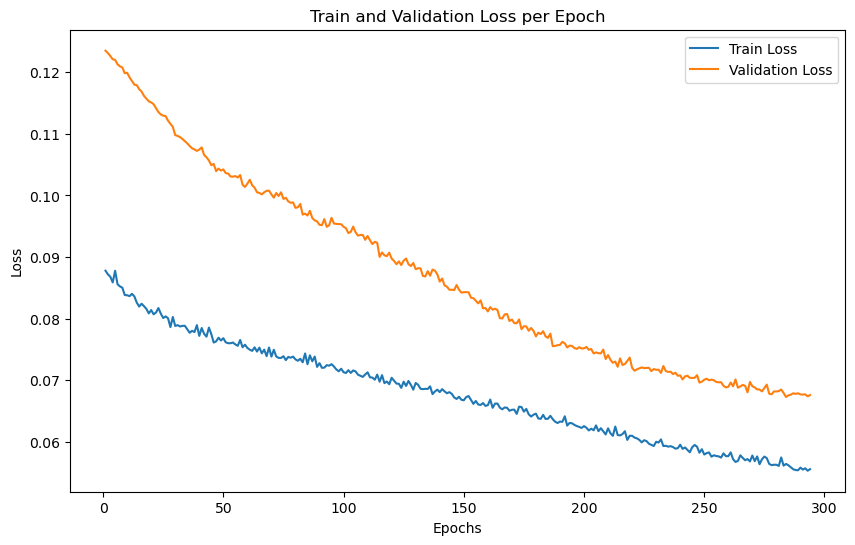

In [326]:
import seaborn as sns
import matplotlib.pyplot as plt

# 손실 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(train_loss_history) + 1), y=train_loss_history, label="Train Loss")
sns.lineplot(x=range(1, len(val_loss_history) + 1), y=val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss per Epoch")
plt.legend()
plt.show()